# Matrix Factorization model on MovieLens 100K

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
from collections import Counter

 ## Data Preprocessing
 - Read the dataset
 - Dropped the `Timestamp` Column
 - Restarted the numberings of ids from 0
 - Changed the dtype of ratings


In [0]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Colab Notebooks/


In [3]:
# read dataset and drop timestamp
path = "ml-100k/u.data"
data = pd.read_csv(path, sep='\s+', names=['UserId', 'MovieId', 'Rating', 'Timestamp'], index_col=None).drop(
    ['Timestamp'], axis=1)

# restarting numbering of ids from 0
print(f"Minimum userid: {np.min(data['UserId'])}, Minimum movieid: {np.min(data['UserId'])}")
data['UserId'] -= 1
data['MovieId'] -= 1
print(f"Minimum userid: {np.min(data['UserId'])}, Minimum movieid: {np.min(data['UserId'])}")

# change dtype of ratings
data = data.astype({'UserId': 'int', 'MovieId': 'int', 'Rating': 'float32'})
data.head()

Minimum userid: 1, Minimum movieid: 1
Minimum userid: 0, Minimum movieid: 0


,UserId,MovieId,Rating
0,195,241,3.0
1,185,301,3.0
2,21,376,1.0
3,243,50,2.0
4,165,345,1.0


- Given a dataframe with userid,movieid and ratings features, `create_ratings_matrix` generates the ratings matrix.
- The function `test_ratings_dims` confirms the sparsity of the ratings matrix

In [0]:
num_users = len(set(data['UserId']))
num_movies = len(set(data['MovieId']))

# create user-item matrix for ratings
def create_ratings_matrix(data):
  ratings_matrix = np.zeros((num_users, num_movies), dtype=float)
  for i in range(len(data)):
      userid, movieid, rating = tuple(data.iloc[i])
      ratings_matrix[int(userid), int(movieid)] = rating
  return ratings_matrix

def test_ratings_dims(ratings_matrix, expected_length):
    num_ratings = 0
    for i in range(ratings_matrix.shape[0]):
        num_ratings += len(np.nonzero(ratings_matrix[i])[0])

    if num_ratings == expected_length:
        #print(f"Alles gut. Number of ratings:{num_ratings}")
        return
    else:
        print("Es gibt ein Problem")
    return 

## Modelling
- `loss` calculates the loss value while `rmse` computes the rmse
- A mask of the ratings matrix is computed with cell values where ratings exist set to 1. 
- This mask is utilzed by both functions

In [0]:
def loss(ratings, model_params, reg):
    user_latent, movie_latent, user_bias, movie_bias, global_bias = model_params
    #reshape the biases so they can be broadcasted approriately by numpy
    user_bias = user_bias.reshape(-1, 1)
    movie_bias = movie_bias.reshape(1, -1)
    #mask to eliminate cell values without ratings
    ratings_mask = (ratings != 0).astype(float)

    prediction = user_latent.dot(movie_latent.T) + user_bias + movie_bias + global_bias
    error = ratings - prediction
    #eliminate cell values without ratings 
    error = error * ratings_mask
    regularizations = np.sum(user_latent ** 2) + np.sum(movie_latent ** 2) + np.sum(user_bias ** 2) + np.sum(
        movie_bias ** 2)

    return np.sum(error ** 2) + reg * regularizations

def rmse(ratings, model_params):
    user_latent, movie_latent, user_bias, movie_bias, global_bias = model_params
    #reshape the biases so they can be broadcasted approriately by numpy
    user_bias = user_bias.reshape(-1, 1)
    movie_bias = movie_bias.reshape(1, -1)

    #mask to eliminate cell values without ratings
    ratings_mask = (ratings != 0).astype(float)
    num_ratings  = np.sum(ratings_mask)

    prediction = user_latent.dot(movie_latent.T) + user_bias + movie_bias + global_bias
    error = ratings - prediction
    #eliminate cell values without ratings 
    error = error * ratings_mask

    return np.sqrt(np.sum(error ** 2)/num_ratings) 

- `matrix_factorizer` performs the matrix factorization
- The `user_latent` and `movie_latent` matrices are randomly initialized.
- The ratings dataset is not normalized and the `user_bias`, `movie_bias` and `global_bias` terms compensate for the bias present in the ratings
- stochastic gradient descent is used to compute the update of the parameters for each rating present in the matrix

In [0]:
def matrix_factorizer(train_ratings, test_ratings, lr=0.005, k=10, epochs=30, reg=0.001, freq=5, print_stats=True):
    # initialization
    user_latent = np.random.random((num_users, k))
    movie_latent = np.random.random((num_movies, k))
    user_bias = np.zeros(num_users)
    movie_bias = np.zeros(num_movies)
    global_bias = data['Rating'].mean()
    #capture the indices of the ratings 
    user_indices, movie_indices = np.nonzero(train_ratings)

    train_losses = []
    test_losses = []
    train_rmses = []
    test_rmses = []

    for epoch in range(epochs):
        for i, j in zip(user_indices, movie_indices):
            prediction = user_latent[i].dot(movie_latent[j].T) + user_bias[i] +\
                         movie_bias[j] + global_bias
            rating = train_ratings[i][j]
            error = rating - prediction 
        
            # stochastic gradient descent update
            user_bias[i] += lr * (error - reg * user_bias[i])
            movie_bias[j] += lr * (error - reg * movie_bias[j])
            user_latent[i] += lr * (error * movie_latent[j] - reg * user_latent[i])
            movie_latent[j] += lr * (error * user_latent[i] - reg * movie_latent[j])

        model_params = user_latent, movie_latent, user_bias, movie_bias, global_bias
        
        train_loss = loss(train_ratings, model_params, reg)
        test_loss = loss(test_ratings, model_params, reg)
        train_rmse = rmse(train_ratings, model_params)
        test_rmse = rmse(test_ratings, model_params)
        
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_rmses.append(train_rmse)
        test_rmses.append(test_rmse)

        if (epoch + 1) % freq == 0 and print_stats==True:
            print(f"Epoch:{epoch + 1:02d} Train loss:{train_loss:.3f} Test loss:{test_loss:.3f}")
            print(f"Epoch:{epoch + 1:02d} Train rmse:{train_rmse:.3f} Test rmse:{test_rmse:.3f}\n")

    return model_params, train_losses, test_losses, train_rmses, test_rmses

- Plot Loss and RMSE for the model

In [0]:
def plot_model_stats(model):
  plt.figure(1)
  plt.ylabel("Loss")
  plt.xlabel("Epochs")
  plt.title("Loss vs Epochs")
  plt.plot(model[1])
  plt.plot(model[2])
  plt.legend(['Train loss','Test loss'])

  plt.figure(2)
  plt.ylabel("RMSE")
  plt.xlabel("Epochs")
  plt.title("RMSE vs Epochs")
  plt.plot(model[3])
  plt.plot(model[4])
  plt.legend(['Train RMSE','Test RMSE'])
  return

- `Kfold` generates indices that split a dataframe with ratings into `k` number of parts
- `Grid_Search` is supplied with 3 matrices: one each for different values of latent dimensions, learning rate and regularization constant
- `Grid_Search` performs Kfold crossvalidation and determines the optimal hyper-parameters 

In [0]:
def Kfold(k,data):
    
    #array of all indices in data
    indices = np.arange(len(data))
    
    #shuffle the indices
    np.random.random(1)
    np.random.shuffle(indices)
    
    #length of each k fold
    splits = int(len(data)//k)
    
    indices = list(indices)
    
    #array to store indices of each fold
    Kfold_indices = []
    for i in range(k-1):
        Kfold_indices.append(indices[i*splits: (i+1)*splits])
    Kfold_indices.append(indices[(k-1)*splits:])
    
    #testing of folds generated
    sum_of_all_groups = 0
    for i in range(k):
        sum_of_all_groups += len(Kfold_indices[i]) 
    assert(len(data) == sum_of_all_groups)
    
    return Kfold_indices

def Grid_Search(data,hyp_params,k=5):
    data_indices = Kfold(k,data)
    latent_dim, learning_rate, reg_const = hyp_params
    #store fold data
    hyp_param_data_store = {}
    
    for m in latent_dim:
      for n in learning_rate:
        for o in reg_const:
  
          running_val_rmse = 0
          for i in range(k):
              train_indices = []
              val_index = data_indices[i]
              for j in range(k):
                  if j != i:
                      train_indices += list(data_indices[j])
            
              data_train = data.iloc[train_indices,:]
              data_val = data.iloc[val_index,:]

              ratings_matrix_train = create_ratings_matrix(data_train)
              ratings_matrix_val = create_ratings_matrix(data_val)

              test_ratings_dims(ratings_matrix_train, len(data_train))
              test_ratings_dims(ratings_matrix_val, len(data_val))

              model = matrix_factorizer(ratings_matrix_train, ratings_matrix_val, \
                                        lr=n, k=m, epochs=30, reg=o, freq=30,print_stats=False)
              
              running_val_rmse += model[4][-1]
              
          average_val_rmse = running_val_rmse/k
          print(f"latent dim:{m}, lr:{n}, reg:{o},Average Validation RMSE:{average_val_rmse}")
          hyp_param_data_store["latent dimension:"+str(m)+\
                               ",learning rate:"+str(n)+\
                               ",Regularization:"+str(o)] = average_val_rmse
    
    best_hyp_params = min([(v,k) for k,v in hyp_param_data_store.items()])
    print(f"Best Params: {best_hyp_params[1]} Best RMSE:{best_hyp_params[0]}")
    return hyp_param_data_store

### Determine Optimal Hyper-parameters

In [9]:
latent_dim = [4,8]
learning_rate = [1e-2,1e-3]
reg_const = [1e-1]

hyp_params = latent_dim, learning_rate, reg_const 
grid_results = Grid_Search(data,hyp_params)

latent dim:4, lr:0.01, reg:0.1,Average Validation RMSE:0.9229466633518089
latent dim:4, lr:0.001, reg:0.1,Average Validation RMSE:0.9600122947189108
latent dim:8, lr:0.01, reg:0.1,Average Validation RMSE:0.9206744903048371
latent dim:8, lr:0.001, reg:0.1,Average Validation RMSE:0.9681948996987277
Best Params: latent dimension:8,learning rate:0.01,Regularization:0.1 Best RMSE:0.9206744903048371


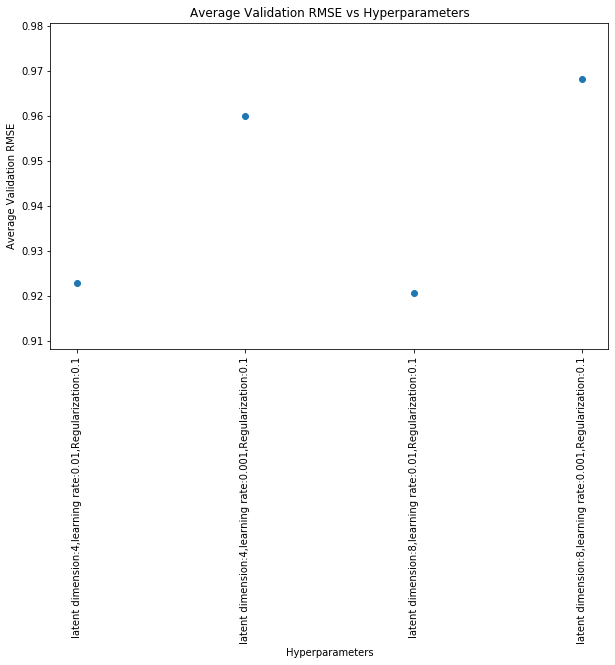

In [10]:
plt.figure(1, figsize=(10,6))
plt.scatter(np.arange(len(grid_results)),list(grid_results.values()))
plt.ylabel("Average Validation RMSE")
plt.xlabel("Hyperparameters")
plt.title("Average Validation RMSE vs Hyperparameters")
xticks = plt.xticks(np.arange(len(grid_results)),grid_results.keys(),rotation=90)

### Test Model
- Testing model with best hyper parameters : latent dimensionality of 8, regularization constant of 0.1, and learning rate of 0.01

Epoch:05 Train loss:67381.380 Test loss:18811.170
Epoch:05 Train rmse:0.915 Test rmse:0.960

Epoch:10 Train loss:63937.530 Test loss:18177.113
Epoch:10 Train rmse:0.892 Test rmse:0.944

Epoch:15 Train loss:61799.958 Test loss:17929.300
Epoch:15 Train rmse:0.877 Test rmse:0.938

Epoch:20 Train loss:59415.177 Test loss:17681.994
Epoch:20 Train rmse:0.860 Test rmse:0.932

Epoch:25 Train loss:57102.001 Test loss:17469.444
Epoch:25 Train rmse:0.843 Test rmse:0.926

Epoch:30 Train loss:55205.729 Test loss:17341.623
Epoch:30 Train rmse:0.828 Test rmse:0.923



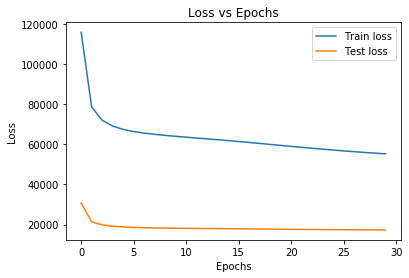

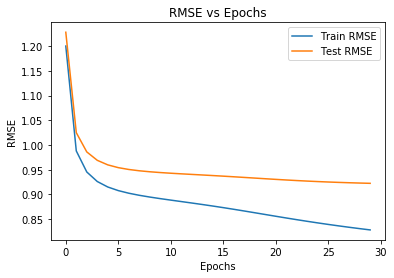

In [11]:
# train/test split
train_set_size = 0.8
data_train = data.sample(frac=train_set_size)
data_test = data.drop(data_train.index)

ratings_matrix_train = create_ratings_matrix(data_train)
ratings_matrix_test = create_ratings_matrix(data_test)

test_ratings_dims(ratings_matrix_train, len(data_train))
test_ratings_dims(ratings_matrix_test, len(data_test))

self_implem_model = matrix_factorizer(ratings_matrix_train,ratings_matrix_test, lr=0.01,\
                          k=8, epochs=30, reg=0.1, freq=5)

plot_model_stats(self_implem_model)

**Comment** Obtained Test RMSE of 0.923